# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

## Домашнее задание

все материалы для выполения дз в `sem2.ipynb`


### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from string import punctuation
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

from collections import Counter
from sklearn.metrics import f1_score
from sklearn import model_selection, preprocessing, linear_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('/negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [4]:
#разбиваем данные на train и test
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

1. Задание 1

In [5]:
#стоп-слова
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [6]:
#знаки пунктуации
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
#шум
noise = stopwords.words('russian') + list(punctuation)
print(noise)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
# список токетов (удаляем пунктуацию)
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [11]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

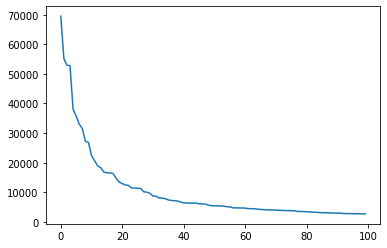

In [12]:
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

In [13]:
#1. Токены с высокой частотой
tokens_hight = [token[0] for token in freq_dict_sorted[:100]]

vec = TfidfVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_hight)
                     # stop_words=noise без чистки шума метрика лучше
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


              precision    recall  f1-score   support

    negative       0.59      0.63      0.61     25917
    positive       0.67      0.63      0.65     30792

    accuracy                           0.63     56709
   macro avg       0.63      0.63      0.63     56709
weighted avg       0.63      0.63      0.63     56709



In [14]:
#2. Токены со средней частотой
tokens_middle = [token[0] for token in freq_dict_sorted[100:300]]
vec = CountVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_middle)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


              precision    recall  f1-score   support

    negative       0.37      0.63      0.47     16599
    positive       0.79      0.56      0.66     40110

    accuracy                           0.58     56709
   macro avg       0.58      0.60      0.56     56709
weighted avg       0.66      0.58      0.60     56709



In [15]:
#3. Токены с низкой частотой
tokens_low = [token[0] for token in freq_dict_sorted[300:1000]]
vec = CountVectorizer(ngram_range=(1, 1), 
                     tokenizer=word_tokenize,
                      vocabulary=tokens_low)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


              precision    recall  f1-score   support

    negative       0.44      0.67      0.53     18202
    positive       0.79      0.59      0.68     38507

    accuracy                           0.62     56709
   macro avg       0.62      0.63      0.61     56709
weighted avg       0.68      0.62      0.63     56709



2. Задание 2

In [16]:
vec = TfidfVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27855
    positive       1.00      1.00      1.00     28854

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



In [17]:
feature_names = vec.get_feature_names()
count_feature = Counter(feature_names)
count_feature_sort = sorted(count_feature.items(), key=lambda x: x[1])
list(count_feature_sort)[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('!', 1),
 ('#', 1),
 ('$', 1),
 ('%', 1),
 ('&', 1),
 ("'", 1),
 ("''", 1),
 ('(', 1),
 (')', 1),
 ('*', 1)]

In [18]:
cool_token = '!'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.87      0.50      0.64     48222
    positive       0.17      0.58      0.26      8487

    accuracy                           0.52     56709
   macro avg       0.52      0.54      0.45     56709
weighted avg       0.77      0.52      0.58     56709



3. Задание 3

In [19]:
vec = CountVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29224
    positive       0.76      0.80      0.78     27485

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [20]:
vec = TfidfVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize, 
                      stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

    negative       0.77      0.77      0.77     27794
    positive       0.78      0.78      0.78     28915

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [21]:
vec = HashingVectorizer(n_features=100, 
                        tokenizer=word_tokenize, 
                        stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

    negative       0.62      0.59      0.60     29426
    positive       0.58      0.61      0.60     27283

    accuracy                           0.60     56709
   macro avg       0.60      0.60      0.60     56709
weighted avg       0.60      0.60      0.60     56709



In [22]:
# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [23]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
vocab_size = 10000
seq_len = 100

def custom_standardization(input_data):
    
    return input_data

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorize_layer =  TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [25]:
embedding_dim=200

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(200, (3)),
    Conv1D(200, (2)),
    GRU(300),
    #GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dense(1)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
10633/10633 [==============================] - 4801s 451ms/step - loss: 0.6935 - accuracy: 0.4937 - val_loss: 0.6930 - val_accuracy: 0.4921
Epoch 2/5
10633/10633 [==============================] - 4889s 460ms/step - loss: 0.6931 - accuracy: 0.4938 - val_loss: 0.6930 - val_accuracy: 0.4921
Epoch 3/5
10633/10633 [==============================] - 4892s 460ms/step - loss: 0.6931 - accuracy: 0.4938 - val_loss: 0.6930 - val_accuracy: 0.4921
Epoch 4/5
10633/10633 [==============================] - 4911s 462ms/step - loss: 0.6931 - accuracy: 0.4938 - val_loss: 0.6930 - val_accuracy: 0.4921
Epoch 5/5
10633/10633 [==============================] - 4975s 468ms/step - loss: 0.6931 - accuracy: 0.4938 - val_loss: 0.6930 - val_accuracy: 0.4921


In [28]:
result = pd.DataFrame(columns=['n_features', 'f1_score'])
    
for i in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
    vec = HashingVectorizer(n_features=i, 
                            tokenizer=word_tokenize, 
                            stop_words=noise)
    bow = vec.fit_transform(x_train)
    clf.fit(bow, y_train)
    pred = clf.predict(vec.transform(x_test))

    f1 = f1_score(y_test, pred)
    result = result.append({'n_features': i, 'f1_score': f1}, ignore_index=True)

result.sort_values(by=['f1_score'], ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extractio

,n_features,f1_score
9,10000.0,0.728977
8,9000.0,0.722789
7,8000.0,0.721886
6,7000.0,0.718845
5,6000.0,0.714995
4,5000.0,0.709139
3,4000.0,0.702772
2,3000.0,0.695202
1,2000.0,0.682476
0,1000.0,0.660484


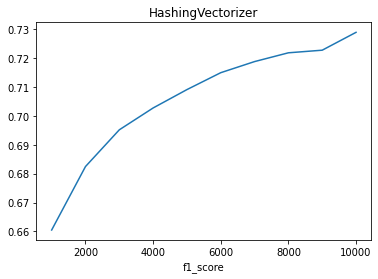

In [29]:
plt.plot(result['n_features'], result['f1_score'])
plt.title('HashingVectorizer')
plt.xlabel("n_features")
plt.xlabel("f1_score")
plt.show()